In [1]:
from minigrid_exp.env import SimpleEnv
from minigrid_exp.data_generation import data_gen
import os

os.environ['PYOPENGL_PLATFORM'] = 'egl'
os.environ['MUJOCO_GL'] = 'egl'


env = SimpleEnv(size=11, agent_start_pos=(1, 1), agent_start_dir=0, render_mode='rgb_array', max_steps=45)

(9, 4)
3
(9, 2)


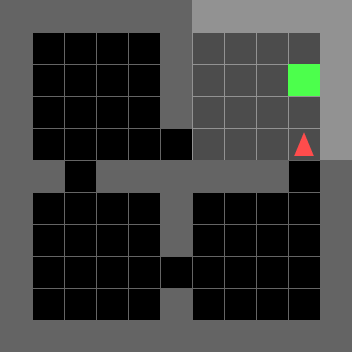

In [2]:
from PIL import Image
obs, _ = env.reset()
print(env.agent_pos)
print(env.agent_dir)
print(env.goal_pos)
display(Image.fromarray(env.render()))

In [3]:
import pickle

# exp_trajs = data_gen(env, total_ep=800)
# rand_trajs = data_gen(env, total_ep=2400, is_random=True)
# with open('./minigrid_exp/expert_minigrid_trajs.pkl', 'wb') as fp:
#     pickle.dump(exp_trajs, fp)
with open('./minigrid_exp/expert_minigrid_trajs.pkl', 'rb') as fp:
    exp_trajs = pickle.load(fp)

In [4]:
print(len(exp_trajs['observations']))
print(len(exp_trajs['actions']))
print(len(exp_trajs['dones']))

5877
5877
5877


In [5]:
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
import shutil
from torch.distributions import Categorical


def eval(env, dataset, policy, test_starting_pos, test_goal_pos, save_dir, is_save=False, is_random=False):
    policy.eval()
    success = []
    os.makedirs(save_dir, exist_ok=True)

    for i, (start, goal) in enumerate(zip(test_starting_pos, test_goal_pos)):
        env.reset(goal_pos = goal)
        env.agent_pos = start[:2]
        env.agent_dir = start[2]
        reward = 0.
        imgs = [Image.fromarray(env.render())]
        
        terminated = False
        while not terminated:
            x, y = env.agent_pos
            d = env.agent_dir
            agent_obs = torch.tensor(dataset.obs_to_one_hot([x, y, d])).to('cuda').float()
            # a = policy(agent_obs, torch.tensor(goal, device='cuda')[None]).argmax(dim=-1)
            # a = policy(agent_obs, None)
            if is_random:
                a = env.action_space.sample()
            else:
                dist = Categorical(logits=policy(agent_obs, None))
                a = dist.sample().cpu().numpy()
                # a = dist.mode.cpu().numpy()
            _, _, terminated, truncated, _ = env.step(a)
            imgs.append(Image.fromarray(env.render()))
            if terminated or truncated:
                reward = float(np.linalg.norm(np.array(env.agent_pos) - np.array(goal)) == 0)
                break
        
        success.append(reward)
        if is_save:
            img_one = imgs[0]
            img_one.save(f'{save_dir}/start:{start}_goal:{goal}_reward:{reward}.gif', format='GIF', append_images=imgs[1:],
               save_all=True, duration=100, loop=0)
    
    success = torch.tensor(success)
    policy.train()
    
    return success


# test_starting_pos = [[5,5,3], [5,5,3], [5,5,3], [5,5,3]]
# test_goal_pos = [[2, 2], [8, 8], [3, 9], [7,1]]
test_starting_pos = [[1, 1, 0], [1, 1, 1], [2, 2, 2], [6, 7, 1], [6, 6, 0], [2, 1, 1], [8, 4, 3], [7, 1, 0], [9, 7, 1], [7, 3, 2], [9, 4, 1], [8, 8, 1]]
test_goal_pos = [[9, 1], [9, 3], [7, 8], [1, 3], [3, 7], [1, 8], [4, 1], [9, 8], [2, 3], [2, 7], [7, 9], [4, 7]]

In [6]:
from minigrid_exp.policies import BCPolicy
from minigrid_exp.minigrid_dataset import MiniGridDataset
from torch.utils.data import DataLoader

traj_dataset = MiniGridDataset(env, exp_trajs)
traj_dataset.update_data()
traj_dataloader = DataLoader(traj_dataset, batch_size=64, shuffle=True)
bc_policy = BCPolicy(len(traj_dataset.all_unique_obs), 256)
bc_policy.to('cuda:0')
CEloss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bc_policy.parameters(), lr=3e-4)
eval_freq = 100

In [7]:
total_steps = int(1e4)
bc_sr_list = []

save_folder = 'video/gcbc'

if os.path.exists(save_folder):
    shutil.rmtree(save_folder)

with tqdm(total=total_steps) as pbar:
    for step in range(total_steps):
        batch = next(iter(traj_dataloader))
        observations, actions, rewards, next_observations, _, masks, oh_actions = batch
        pred_logits = bc_policy(observations.to('cuda:0').float(), None)
        loss = CEloss(pred_logits, actions.to('cuda:0').view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)

        if step > 9000 and (step + 1) % eval_freq == 0:
            with torch.no_grad():
                success = eval(env, traj_dataset, bc_policy, test_starting_pos, test_goal_pos, f'{save_folder}/eval_{(step + 1) // eval_freq}', is_save=True)
                sr = success.mean().item()
            bc_sr_list.append(sr)

print(bc_sr_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:25<00:00, 68.87it/s, loss=0.561]

[0.1666666716337204, 0.0833333358168602, 0.0, 0.1666666716337204, 0.0833333358168602, 0.25, 0.0, 0.0833333358168602, 0.0833333358168602, 0.1666666716337204]


In [8]:
import itertools
from torch.distributions import Categorical
from minigrid_exp.policies import IQL

save_folder = 'video/gciql'

if os.path.exists(save_folder):
    shutil.rmtree(save_folder)

def expectile_loss(pred, target, expectile=0.5):
    diff = pred - target
    weight = torch.where(diff > 0, expectile, (1 - expectile))
    return weight * (diff ** 2)

def one_hot_action(a: int, n_actions: int):
    return torch.eye(n_actions)[a]

iql_sr_dict = {}

for starting_pos, eval_goal in zip(test_starting_pos, test_goal_pos):
    traj_dataset.update_data(eval_goal=eval_goal)
    iql_sr_dict[tuple(eval_goal)] = []
    iql_policy = IQL(len(traj_dataset.all_unique_obs), 256, 4, 0.005).to('cuda')
    gamma = 0.99
    expectile = 0.9
    temp = 10.0
    clip_score = 100.0
    target_update_freq = 1
    total_steps = int(1e4)

    # actor_optim = torch.optim.Adam(itertools.chain(iql_policy.actor.parameters(), iql_policy.obs_enc.parameters()), lr=3e-4)
    actor_optim = torch.optim.Adam(iql_policy.actor.parameters(), lr=3e-4)
    critic_optim = torch.optim.Adam(iql_policy.critic.parameters(), lr=3e-4)
    value_optim = torch.optim.Adam(iql_policy.value.parameters(), lr=3e-4)

    with tqdm(total=total_steps) as pbar:
        for step in range(total_steps):
            batch = next(iter(traj_dataloader))
            observations, actions, rewards, next_observations, _, masks, oh_actions = batch

            # with torch.no_grad():
            #     next_obs_emb = iql_policy.obs_enc(next_observations.to('cuda'), None)
            # obs_emb = iql_policy.obs_enc(observations.to('cuda'), None)
            observations = observations.to('cuda').float()
            next_observations = next_observations.to('cuda').float()
            with torch.no_grad():
                target_q1, target_q2 = iql_policy.target_critic_forward(observations, oh_actions.to('cuda'))
                target_q_min = torch.cat([target_q1, target_q2], dim=-1).min(dim=-1).values
            
            v = iql_policy.value_forward(observations)
            value_loss = expectile_loss(target_q_min, v, expectile=expectile).mean(dim=-1).sum()

            value_optim.zero_grad(set_to_none=True)
            value_loss.backward()
            value_optim.step()

            with torch.no_grad():
                next_v = iql_policy.value_forward(next_observations)
                target = rewards.to('cuda') + gamma * masks.to('cuda') * next_v.view(-1)

            q1, q2 = iql_policy.critic_forward(observations, oh_actions.to('cuda'))
            critic_loss = ((target - q1) ** 2 + (target - q2) ** 2).mean(dim=-1).sum()

            critic_optim.zero_grad(set_to_none=True)
            critic_loss.backward()
            critic_optim.step()

            with torch.no_grad():
                adv = target_q_min - v.view(-1)
                exp_adv = torch.exp(temp * adv)
                if clip_score is not None:
                    exp_adv = torch.clamp(exp_adv, max=clip_score)
            dist = Categorical(logits=iql_policy.actor_forward(observations.to('cuda')))
            actor_loss = (exp_adv * -dist.log_prob(actions.to('cuda').view(-1))).sum(dim=-1)

            actor_optim.zero_grad(set_to_none=True)
            actor_loss.backward()
            actor_optim.step()

            if step % target_update_freq == 0:  # update target
                iql_policy.target_update()

            # actor_optim.zero_grad(set_to_none=True)
            # critic_optim.zero_grad(set_to_none=True)
            # value_optim.zero_grad(set_to_none=True)
            # (actor_loss + value_loss + critic_loss).backward()
            # actor_optim.step()
            # critic_optim.step()
            # value_optim.step()
            pbar.set_postfix({'value_loss': value_loss.item(), 'critic_loss': critic_loss.item(), 'actor_loss': actor_loss.item()})
            pbar.update(1)

            if step > 9000 and (step + 1) % eval_freq == 0:
                with torch.no_grad():
                    success = eval(env, traj_dataset, iql_policy, [starting_pos], [eval_goal], f'{save_folder}/eval_{(step + 1) // eval_freq}', is_save=True)
                    sr = success.mean().item()
                iql_sr_dict[tuple(eval_goal)].append(sr)

print(iql_sr_dict)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:04<00:00, 80.26it/s, value_loss=16.6, critic_loss=19.2, actor_loss=0.00794]

{(9, 1): [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], (9, 3): [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0], (7, 8): [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], (1, 3): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (3, 7): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (1, 8): [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0], (4, 1): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], (9, 8): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], (2, 3): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (2, 7): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (7, 9): [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0], (4, 7): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


In [9]:
iql_sr_array = []
for key, value in iql_sr_dict.items():
    iql_sr_array.append(value)

iql_sr_array = np.array(iql_sr_array)
print(iql_sr_array.shape)
iql_srs = np.mean(iql_sr_array, axis=0)
iql_srs

(12, 10)


array([0.25      , 0.        , 0.16666667, 0.        , 0.16666667,
       0.08333333, 0.08333333, 0.33333333, 0.08333333, 0.16666667])

In [10]:
# observations = torch.tensor([traj_dataset.obs_to_one_hot([6, 4, 0])])
# obs_emb = iql_policy.obs_enc(observations.to('cuda'), None)
# action = torch.tensor([[0,0,1,0]]).to('cuda')
# print(iql_policy.value_forward(obs_emb))
# print(iql_policy.actor_forward(obs_emb))
# print(iql_policy.critic_forward(obs_emb, action))

In [11]:
# import h5py

# filename = '/users/zzeng28/.d4rl/datasets/Ant_maze_hardest-maze_noisy_multistart_True_multigoal_True_sparse_fixed.hdf5'

# with h5py.File(filename, 'r') as f:
#     observations = f['observations'][()]
#     terminals = np.array(f['terminals'][()])
#     rewards = np.array(f['rewards'][()])
#     print(np.argwhere(terminals == 1.).shape)
#     print(np.argwhere(rewards == 1.).shape)